In [2]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("samples-20230530T064900Z-001.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="")


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt
import os
print(os.listdir("./samples"))

# Any results you write to the current directory are saved as output.

['226md.png', '22d5n.png', '2356g.png', '23mdg.png', '23n88.png', '243mm.png', '244e2.png', '245y5.png', '24f6w.png', '24pew.png', '25257.png', '253dc.png', '25egp.png', '25m6p.png', '25p2m.png', '25w53.png', '264m5.png', '268g2.png', '28348.png', '28x47.png', '2b827.png', '2bg48.png', '2cegf.png', '2cg58.png', '2cgyx.png', '2en7g.png', '2enf4.png', '2fxgd.png', '2g783.png', '2g7nm.png', '2gyb6.png', '2mg87.png', '2mpnn.png', '2n73f.png', '2nbc5.jpg', '2nbcx.png', '2nf26.png', '2npg6.png', '2nx38.png', '2p2y8.png', '2pfpn.png', '2w4y7.png', '2wc38.png', '2wx73.png', '2x7bm.png', '2xc2n.png', '2ycn8.png', '2yggg.png', '325fb.png', '32cnn.png', '32dnn.png', '33b22.png', '33f7m.png', '33n73.png', '33ng4.png', '33p4e.png', '34b84.png', '34fxm.png', '34pcn.png', '368y5.png', '36bc2.png', '36nx4.png', '36w25.png', '373gb.png', '377xx.png', '378e5.png', '37d52.png', '37ep6.png', '387g2.png', '38n57.png', '3b4we.png', '3bd8f.png', '3bnfnd.png', '3bnyf.png', '3bx86.png', '3c7de.jpg', '3cpwb.png

In [6]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

2023-05-30 12:35:02.451689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 12:35:04.055645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-30 12:35:04.055785: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-30 12:35:08.914607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-30

In [7]:
print(num_symbols)

36


In [8]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [10]:
def preprocess_data():
    n_samples = len(os.listdir('samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [11]:
model=create_model();
model.summary();

2023-05-30 12:36:50.599587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mrizwan/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-30 12:36:50.600885: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-30 12:36:50.601376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-PV5U7I0): /proc/driver/nvidia/version does not exist
2023-05-30 12:36:50.608773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate comp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d[0][0]']      

In [12]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 21s 499ms/step - loss: 18.0918 - dense_1_loss: 3.4811 - dense_3_loss: 3.6925 - dense_5_loss: 3.6578 - dense_7_loss: 3.6374 - dense_9_loss: 3.6229 - dense_1_accuracy: 0.0541 - dense_3_accuracy: 0.0554 - dense_5_accuracy: 0.0425 - dense_7_accuracy: 0.0799 - dense_9_accuracy: 0.0348 - val_loss: 17.7651 - val_dense_1_loss: 3.5962 - val_dense_3_loss: 3.5318 - val_dense_5_loss: 3.5363 - val_dense_7_loss: 3.5440 - val_dense_9_loss: 3.5569 - val_dense_1_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.0567 - val_dense_5_accuracy: 0.0515 - val_dense_7_accuracy: 0.0515 - val_dense_9_accuracy: 0.0876
Epoch 2/30
25/25 [==============================] - 11s 420ms/step - loss: 16.9618 - dense_1_loss: 3.1917 - dense_3_loss: 3.3899 - dense_5_loss: 3.4706 - dense_7_loss: 3.4777 - dense_9_loss: 3.4319 - dense_1_accuracy: 0.0735 - dense_3_accuracy: 0.0735 - dense_5_accuracy: 0.0606 - dense_7_accuracy: 0.0696 - dense_9_accuracy: 0.0503 - val_loss: 17.7683 

Epoch 14/30
25/25 [==============================] - 12s 494ms/step - loss: 5.6888 - dense_1_loss: 0.4064 - dense_3_loss: 0.7275 - dense_5_loss: 1.8110 - dense_7_loss: 1.4340 - dense_9_loss: 1.3099 - dense_1_accuracy: 0.8479 - dense_3_accuracy: 0.7345 - dense_5_accuracy: 0.3737 - dense_7_accuracy: 0.4858 - dense_9_accuracy: 0.5477 - val_loss: 12.5542 - val_dense_1_loss: 4.7032 - val_dense_3_loss: 1.4858 - val_dense_5_loss: 2.3032 - val_dense_7_loss: 2.1529 - val_dense_9_loss: 1.9092 - val_dense_1_accuracy: 0.0052 - val_dense_3_accuracy: 0.7887 - val_dense_5_accuracy: 0.6082 - val_dense_7_accuracy: 0.6598 - val_dense_9_accuracy: 0.6959
Epoch 15/30
25/25 [==============================] - 13s 534ms/step - loss: 5.1860 - dense_1_loss: 0.3898 - dense_3_loss: 0.6626 - dense_5_loss: 1.6127 - dense_7_loss: 1.3250 - dense_9_loss: 1.1959 - dense_1_accuracy: 0.8505 - dense_3_accuracy: 0.7655 - dense_5_accuracy: 0.4472 - dense_7_accuracy: 0.5180 - dense_9_accuracy: 0.5554 - val_loss: 12.3110 - va

Epoch 27/30
25/25 [==============================] - 12s 477ms/step - loss: 2.8062 - dense_1_loss: 0.1595 - dense_3_loss: 0.3528 - dense_5_loss: 0.7651 - dense_7_loss: 0.8638 - dense_9_loss: 0.6650 - dense_1_accuracy: 0.9356 - dense_3_accuracy: 0.8789 - dense_5_accuracy: 0.7010 - dense_7_accuracy: 0.6907 - dense_9_accuracy: 0.7564 - val_loss: 14.2024 - val_dense_1_loss: 11.3635 - val_dense_3_loss: 0.6238 - val_dense_5_loss: 0.8229 - val_dense_7_loss: 0.8193 - val_dense_9_loss: 0.5730 - val_dense_1_accuracy: 0.0619 - val_dense_3_accuracy: 0.8660 - val_dense_5_accuracy: 0.7371 - val_dense_7_accuracy: 0.7732 - val_dense_9_accuracy: 0.7938
Epoch 28/30
25/25 [==============================] - 12s 485ms/step - loss: 2.6681 - dense_1_loss: 0.1625 - dense_3_loss: 0.3174 - dense_5_loss: 0.7479 - dense_7_loss: 0.7817 - dense_9_loss: 0.6585 - dense_1_accuracy: 0.9278 - dense_3_accuracy: 0.8827 - dense_5_accuracy: 0.7178 - dense_7_accuracy: 0.6894 - dense_9_accuracy: 0.7423 - val_loss: 13.5980 - v

In [13]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [14]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 0s 99ms/step - loss: 21.3847 - dense_1_loss: 19.0186 - dense_3_loss: 0.1573 - dense_5_loss: 0.8253 - dense_7_loss: 0.9314 - dense_9_loss: 0.4521 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9400 - dense_5_accuracy: 0.7100 - dense_7_accuracy: 0.7800 - dense_9_accuracy: 0.8900
Test Loss and accuracy: [21.384695053100586, 19.018613815307617, 0.15732510387897491, 0.8252820372581482, 0.9313899874687195, 0.4520830810070038, 0.0, 0.9399999976158142, 0.7099999785423279, 0.7799999713897705, 0.8899999856948853]


In [16]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('samples/8n5p3.png'))
print(predict('samples/f2m8n.png'))
print(predict('samples/dce8y.png'))
print(predict('samples/3eny7.png'))
print(predict('samples/npxb7.png'))

1/1 [==============================] - 0s 344ms/step
8n5p3
1/1 [==============================] - 0s 55ms/step
f2m8n
1/1 [==============================] - 0s 57ms/step
dce8y
1/1 [==============================] - 0s 50ms/step
3eny7
1/1 [==============================] - 0s 47ms/step
mpxb7


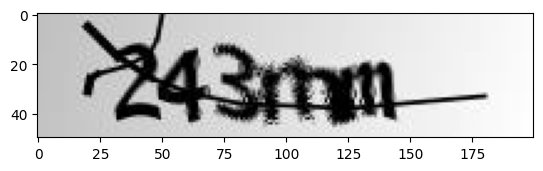

In [21]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('samples/243mm.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [22]:
#Lets Predict By Model
print("Predicted Captcha =",predict('samples/243mm.png'))

1/1 [==============================] - 0s 65ms/step
Predicted Captcha = 243mm


1/1 [==============================] - 0s 43ms/step
Predicted Captcha = 2458w
1/1 [==============================] - 0s 48ms/step
x458w
1/1 [==============================] - 0s 45ms/step
Predicted Captcha = 24f7g
1/1 [==============================] - 0s 52ms/step
x4f7g
1/1 [==============================] - 0s 53ms/step
Predicted Captcha = 24gg5
1/1 [==============================] - 0s 50ms/step
x4gg5
1/1 [==============================] - 0s 47ms/step
Predicted Captcha = 74pnp
1/1 [==============================] - 0s 58ms/step
x4pnp
1/1 [==============================] - 0s 49ms/step
Predicted Captcha = 75f54
1/1 [==============================] - 0s 50ms/step
x5f54
1/1 [==============================] - 0s 49ms/step
Predicted Captcha = 25nym
1/1 [==============================] - 0s 72ms/step
x5nyn
1/1 [==============================] - 0s 78ms/step
Predicted Captcha = m6b5m
1/1 [==============================] - 0s 71ms/step
x6b5m
1/1 [==============================] - 0s 53ms/s

1/1 [==============================] - 0s 57ms/step
Predicted Captcha = 75g87
1/1 [==============================] - 0s 64ms/step
y5g87
1/1 [==============================] - 0s 62ms/step
Predicted Captcha = g6m6d
1/1 [==============================] - 0s 62ms/step
y5n6d
1/1 [==============================] - 0s 70ms/step
Predicted Captcha = 25m78
1/1 [==============================] - 0s 57ms/step
y5w28
1/1 [==============================] - 0s 65ms/step
Predicted Captcha = g7d75
1/1 [==============================] - 0s 69ms/step
y7d75
1/1 [==============================] - 0s 60ms/step
Predicted Captcha = 77mnm
1/1 [==============================] - 0s 68ms/step
y7mnm
1/1 [==============================] - 0s 57ms/step
Predicted Captcha = 77x8p
1/1 [==============================] - 0s 63ms/step
y7x8p
1/1 [==============================] - 0s 52ms/step
Predicted Captcha = g2f6y
1/1 [==============================] - 0s 55ms/step
y866y
1/1 [==============================] - 0s 72ms/s

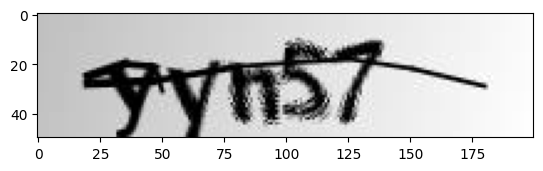

In [25]:
# testing
c=0
for i, pic in enumerate(os.listdir('samples')):
#         Read image as grayscale
        
        if i>970:    

            img = cv2.imread(os.path.join('samples', pic), cv2.IMREAD_GRAYSCALE)
            print("Predicted Captcha =",predict(os.path.join('samples',pic)))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            pr=predict(os.path.join('samples',pic))
            pic_target = pic[:-4]
            if pr==pic_target:
                c=c+1
                print(c)
            print(pic_target)
print((c/100)*100)